# Huggingface Natural Language Inference
This notebook tutorial is taken from the Huggingface website (https://huggingface.co/docs/transformers/tasks/) and modified for CSCI5541. Today we will be:
1. Learning about the concepts of pre-training and fine-tuning
2. Finetuning [DistilBERT](https://huggingface.co/distilbert-base-uncased) on the [SNLI](https://huggingface.co/datasets/snli) which is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI).
3. Using your finetuned model for inference.
4. Compare the model with the leaderboards top models to see how well it performs.



## Pre-Training and Fine-Tuning
Pre-training:
- The process of training a neural network on a large dataset before fine-tuning it for a specific task
- Allows the network to learn useful features and representations that can be used to improve performance
- Saves time and computing resources since the model doesn't need to learn about a new task/domain from scratch

Fine-Tuning:
- The process of training a pre-trained model on a new, smaller dataset
- Improves performance since the model learns information specific to the task at hand

finetune.svg
<a href="https://d2l.ai/chapter_computer-vision/fine-tuning.html">Image source</a>

## Let's start fine-tuning!
### 1. Load dataset

In [ ]:
%%capture
# Use this only after you check everything is being loaded properly

# First install necessary libraries
# Exclamation marks for shell commands
! pip install transformers datasets evaluate scikit-learn
! pip install accelerate -U

In [ ]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

We will be using the SNLI (Stanford Natural Language Inference) dataset from the 🤗 Datasets library:

In [ ]:
from datasets import load_dataset

dataset = load_dataset('snli')

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

There are two fields in this dataset:

- `text`: the movie review text.
- `label`: a value that is either `0` for a negative review or `1` for a positive review.

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

Then take a look at an example:

In [ ]:
dataset["train"][0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

In [ ]:
print(f"before: {len(dataset['train'])} rows")
dataset = dataset.filter(
    lambda x: True if x['label'] != -1 else False
)

# filtered_data = test_data.filter(lambda example: example['label'] != -1)

print(f"after: {len(dataset['train'])} rows")

before: 550152 rows


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

after: 549367 rows


<!-- ### 2. Preprocess -->

The next step is to load a tokenizer to preprocess the `text` field.
A tokenizer converts text to a sequence of tokens and creates numerical representation.
Notice how there are multiple ways to tokenize text. Make sure to use the right tokenizer for your model.

In [ ]:
from transformers import AutoTokenizer

distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_cased_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

text = "Hello everyone!"

for tokenizer in [distilbert_tokenizer, bert_cased_tokenizer, roberta_tokenizer]:
  print(f"\n\n{tokenizer.name_or_path}")
  vocab = {v: k for k, v in tokenizer.vocab.items()}
  tokenized_text = tokenizer(text)
  print([vocab[id] for id in tokenized_text['input_ids']])

tokenizer = distilbert_tokenizer



distilbert-base-uncased
['[CLS]', 'hello', 'everyone', '!', '[SEP]']


bert-base-cased
['[CLS]', 'Hello', 'everyone', '!', '[SEP]']


roberta-base
['<s>', 'Hello', 'Ġeveryone', '!', '</s>']


Create a preprocessing function to tokenize `text`. You can specify how to deal with varying input lengths here using the max_length, truncation, and/or padding arguments. (Default is to not truncate or pad. Max length is determined by model.)

https://huggingface.co/docs/transformers/pad_truncation

In [ ]:
def preprocess_function(examples):
    # return tokenizer(examples["text"], truncation=True)
    tokenized_inputs = tokenizer(examples["premise"], examples["hypothesis"], truncation=True)
    return tokenized_inputs

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once.

In [ ]:
# tokenized_imdb = imdb.map(preprocess_function, batched=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Now create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximium length in the tokenzation process.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3. Create evaluation method

Including a metric during training is often helpful for evaluating your model's performance (otherwise, it just prints the loss). You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [ ]:
import evaluate

# Proportion of correct predictions among the total number of cases processed
accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

### 4. Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`.

In [ ]:
id2label = {0: "ENTAILMENT", 1: "NEUTRAL", 2: "CONTRADICTION"}
label2id = {"ENTAILMENT": 0, "NEUTRAL": 1, "CONTRADICTION": 2}

Next, we will be using the Trainer class, which is wrapper code that abstracts away the details of training and evaluation. It is optimized for training 🤗 Transformers and makes it easier for us to train models without writing much code.

[More info on Trainers](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)<br/>
[Trainer Tutorial](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# This automodel class gives us the model with pretrained weights + a sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model (may take some time).

In [ ]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


In [ ]:
import time
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import torch
from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    def _inner_training_loop(
    self , batch_size=None , args=None , resume_from_checkpoint=None , trial=None ,
    ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]
        eval_loss=[]
        epoch_list = []  # For storing epoch numbers
        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer , 1, gamma=0.9)
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()
        max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader , unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step , inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad ()
                    # output = ... # TODO Implement by yourself
                    output = model(**inputs)
                    loss = criterion(output['logits'], labels)
                    # get the loss
                    # loss = criterion (( output [?], labels) # TODO Implement by yourself
                    train_loss_per_epoch += loss.item()
                    # calculate gradients
                    loss.backward ()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader , unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                # ... TODO Implement by yourself
                for eval_inputs in eval_epoch:
                    eval_inputs = {key: val.to(device) for key, val in eval_inputs.items()}
                    eval_labels = eval_inputs['labels']
                    eval_outputs = model(**eval_inputs)
                    eval_loss_per_epoch += criterion(eval_outputs.logits, eval_labels).item()
                    eval_acc_per_epoch += (eval_outputs.logits.argmax(dim=1) == eval_labels).sum().item()

            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            print(f'\tTrain Loss: {train_loss_per_epoch :.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch :.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')

            # Append the epoch number
            epoch_list.append(epoch + 1)

            # Append accuracy and loss
            train_acc.append(train_acc_per_epoch * 100)
            eval_acc.append(eval_acc_per_epoch * 100)
            train_loss.append(train_loss_per_epoch * 100)
            eval_loss.append(eval_loss_per_epoch * 100)
        print(f'Time: {(time.time()-start)/60:.3f} minutes ')


        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, train_acc, label="Training Accuracy", marker='o')
        plt.plot(epoch_list, eval_acc, label="Validation Accuracy", marker='o')
        plt.title('Accuracy Curve Graph')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.xticks(epoch_list)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(epoch_list, train_loss, label="Training Loss", marker='o')
        plt.plot(epoch_list, eval_loss, label="Validation Loss", marker='o')
        plt.title('Loss Curve Graph')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (%)')
        plt.xticks(epoch_list)
        plt.legend()
        plt.grid(True)
        plt.show()

Evaluation Epoch 0: 100%|██████████| 308/308 [00:13<00:00, 23.47batch/s]


	Train Loss: 0.401 | Train Acc: 84.68%
	Eval Loss: 0.315 | Eval Acc: 88.21%


Evaluation Epoch 1: 100%|██████████| 308/308 [00:13<00:00, 23.46batch/s]


	Train Loss: 0.262 | Train Acc: 90.59%
	Eval Loss: 0.302 | Eval Acc: 88.83%
Time: 78.774 minutes 


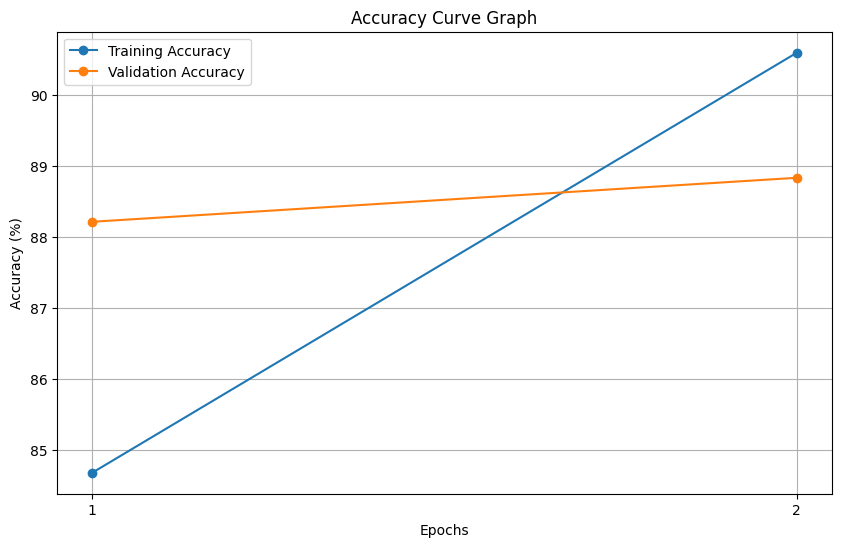

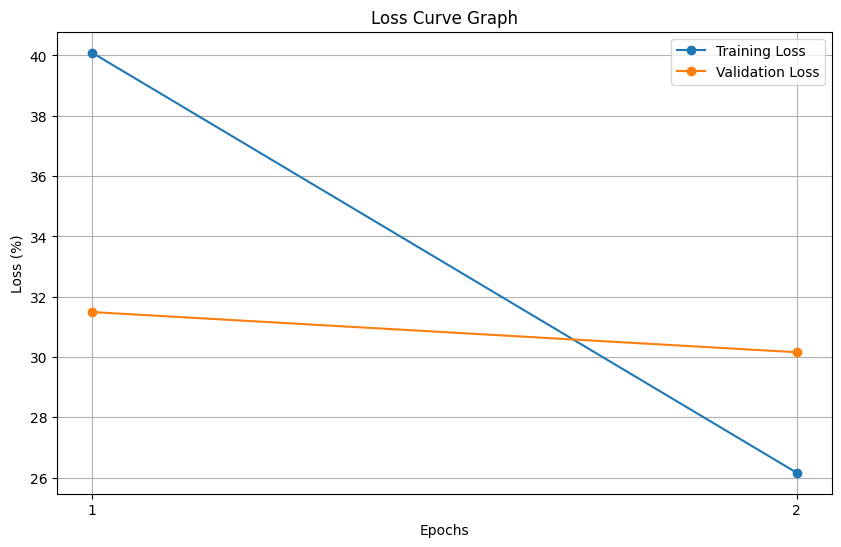

In [ ]:
# https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html#id1
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["test"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )
trainer.train()

In [ ]:
model.save_pretrained("my_awesome_model_2_epoch")

<Tip>

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) applies dynamic padding by default when you pass `tokenizer` to it. In this case, you actually don't need to specify a data collator explicitly because we're not using any special data collation logic.


<Tip>

For a more in-depth example of how to finetune a model for text classification, take a look at the corresponding
[PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb)
or [TensorFlow notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification-tf.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Grab some text you'd like to run inference on:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    with tqdm(data_loader , unit="batch") as training_epoch:
      for step , inputs in enumerate(training_epoch):
          inputs = inputs.to(device)
          targets = inputs['labels']


          outputs = model(**inputs)

          _, preds = torch.max(outputs.logits, dim=1)

          loss = loss_fn(outputs.logits, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)
test_data_loader = trainer.get_test_dataloader( tokenized_dataset["test"])

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(dataset["test"])
)

test_acc.item()

100%|██████████| 307/307 [00:13<00:00, 22.56batch/s]


0.8890472312703583

As observed above, the accuracy is about 1% higher on the test set. So, our model seems to generalize well.

In [ ]:
train_dataloader = trainer.get_train_dataloader()
data = next(iter(train_dataloader))
data.keys()
tokenized_dataset["test"][0]
test_data_loader = trainer.get_test_dataloader( tokenized_dataset["test"])

# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['labels'].shape)


In [ ]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    with tqdm(data_loader , unit="batch") as training_epoch:
      for step , inputs in enumerate(training_epoch):
          inputs = inputs.to(device)

          # premise = inputs['premise']
          # hypothesis = inputs['hypothesis']
          targets = inputs['labels']

          outputs = model(**inputs)

          _, preds = torch.max(outputs.logits, dim=1)

          probs = F.softmax(outputs.logits, dim=1)

          # review_premise.extend(premise)
          # review_hypothesis.extend(hypothesis)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  # return review_texts, predictions, prediction_probs, real_values
  # return review_premise,review_hypothesis, predictions, prediction_probs, real_values
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

100%|██████████| 307/307 [00:13<00:00, 22.86batch/s]


In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
class_names = ["ENTAILMENT", "NEUTRAL", "CONTRADICTION"]
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

   ENTAILMENT       0.92      0.90      0.91      3368
      NEUTRAL       0.84      0.87      0.85      3219
CONTRADICTION       0.92      0.90      0.91      3237

     accuracy                           0.89      9824
    macro avg       0.89      0.89      0.89      9824
 weighted avg       0.89      0.89      0.89      9824



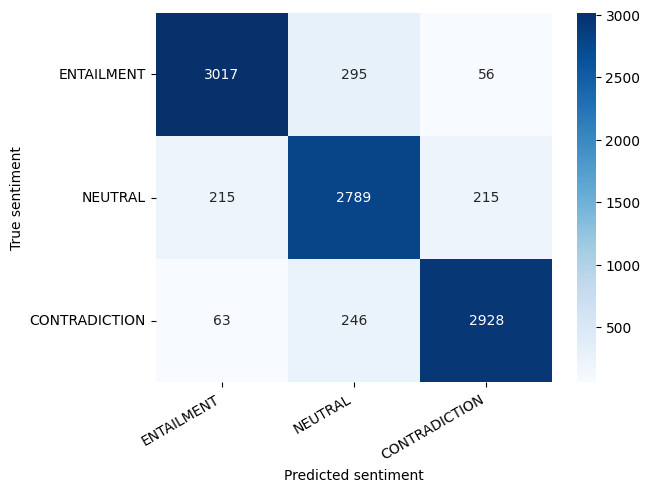

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
test_premise = dataset["test"][35]['premise']
test_hypothesis = dataset["test"][35]['hypothesis']
test_label = dataset["test"][35]['label']

print(test_premise)
print(test_hypothesis)
print(test_label)
print()
print('-------------------')
print()



A man reads the paper in a bar with green lighting.
The man is climbing a mountain.
2


In [ ]:
# from transformers import DistilBertModel, DistilBertTokenizer

# # Load the DistilBERT model and tokenizer
model_name = "distilbert-base-uncased"  # You can replace this with the name of your specific DistilBERT model
# model = DistilBertModel.from_pretrained(model_name)

# Get the hidden size of the model
hidden_size = model.config.hidden_size

print(f"Hidden Size of {model_name}: {hidden_size}")

Hidden Size of distilbert-base-uncased: 768


In [ ]:
# def eval_model(model, data_loader, loss_fn, device, n_examples):
#   model = model.eval()

#   stacks = []
#   stack = []

#   with torch.no_grad():
#     for d in enumerate(training_epoch):
#       inputs = inputs.to(device)
#       targets = inputs['labels']


#       outputs = model(**inputs)

#       _, preds = torch.max(outputs.logits, dim=1)

#       loss = loss_fn(outputs.logits, targets)
#       if preds!= targets:
#         print(f"preds: {preds}, targets: {targets}")

#       correct_predictions += torch.sum(preds == targets)
#       losses.append(loss.item())

#   return [preds, targets]

In [ ]:
# loss_fn = torch.nn.CrossEntropyLoss().to(device)
# test_data_loader = trainer.get_test_dataloader( tokenized_dataset["test"])

# test_acc, _ = eval_model(
#   model,
#   tokenized_dataset["test"],
#   loss_fn,
#   device,
#   len(dataset["test"])
# )

# test_acc.item()

## Model/Dateset Cards in Huggingface (Documentation)

Markdown files with information on how to use the model/dataset and other relevant data (metadata, potential limitations, etc.)

Looking for models/datasets to use:<br/>
https://huggingface.co/models<br/>
https://huggingface.co/datasets

More information:<br/>
https://huggingface.co/docs/hub/model-cards<br/>
https://huggingface.co/docs/hub/datasets-cards

Templates:<br/>
https://github.com/huggingface/huggingface_hub/blob/main/src/huggingface_hub/templates/modelcard_template.md<br/>
https://github.com/huggingface/huggingface_hub/blob/main/src/huggingface_hub/templates/datasetcard_template.md
